# Classification using Bag-of-Words

In this tutorial, I will be going through a classification task using the [Bag-of-Words](https://en.wikipedia.org/wiki/Bag-of-words_model) approach. The aim of this approach 
is to build a vectorized representation of text from a given list of documents. To build this representation, the order and structure of words in a document, but 
the presence of words and their frequency is utilized.

For an example use of this approach, we will be building a model that:
- Given a list of ingredients for a recipe, predicts which *cuisine* it belongs to. The dataset for this task can be obtained from [Kaggle](https://www.kaggle.com/datasets/kaggle/recipe-ingredients-dataset).
- We will use the **TF-IDF** method to vectorize text

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk

# If not downloaded already, uncomment the lines below
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')

In [31]:
# Custom plotting

%matplotlib inline
import matplotlib_inline
import matplotlib.pyplot as plt

matplotlib_inline.backend_inline.set_matplotlib_formats('retina')
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'text.usetex': True, 'font.family': 'serif'})

## 1.1 Data

Let's read the data into a pandas dataframe and check its contents.

In [2]:
df = pd.read_json("../data/train.json")
print(f"Total number of samples: {df.shape[0]}")
print(df.columns)

Total number of samples: 39774
Index(['id', 'cuisine', 'ingredients'], dtype='object')


The column `ingredients` is a list of ingredients for a given recipe; while the column `cuisine` is the target column.

In [3]:
df.iloc[0]

id                                                         10259
cuisine                                                    greek
ingredients    [romaine lettuce, black olives, grape tomatoes...
Name: 0, dtype: object

Check the output labels and their distribution within the dataset.

In [4]:
df["cuisine"].value_counts(normalize=True).sort_values(ascending=False)

cuisine
italian         0.197063
mexican         0.161865
southern_us     0.108614
indian          0.075502
chinese         0.067205
french          0.066526
cajun_creole    0.038870
thai            0.038694
japanese        0.035777
greek           0.029542
spanish         0.024865
korean          0.020868
vietnamese      0.020742
moroccan        0.020642
british         0.020214
filipino        0.018982
irish           0.016770
jamaican        0.013225
russian         0.012294
brazilian       0.011741
Name: proportion, dtype: float64

- Given that the output label space consists of 20 classes, for the sake of keeping things simpe for this tutorial we will narrow down the scope of the problem to top 6 most prevalent labels, plus a `other` class to accomodate all other classes.

In [5]:
top_6_classes = ['italian', 'mexican', 'southern_us', 'indian', 'chinese', 'french']
df['scoped_cuisine'] = df['cuisine'].map(lambda x: x if x in top_6_classes else 'other')

## 1.2 Train-Test Split 

We will split the dataset into train and test set. The train set will be used for model training and model selection, while the test set will be used to evaluate the performance of the final model.

In [6]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, random_state=42, test_size=0.2)

print("Train: ", df_train.shape)
print("Test: ", df_test.shape)

Train:  (31819, 4)
Test:  (7955, 4)


We collect all the ingredients as a list of lists, one for each recipe. We are going to name them `*_raw` as they haven't been converted to fixed length vectors yet.

In [7]:
X_train_raw = df_train['ingredients'].to_list()
y_train = df_train['scoped_cuisine'].to_numpy()

X_test_raw = df_test['ingredients'].to_list()
y_test = df_test['scoped_cuisine'].to_numpy()

## 1.3 Text Vectorization

As stated above, we will be using **TF-IDF** to vectorize the text. But before we do that, let's have a look at some input data.

In [8]:
X_train_raw[1][:10]

['fresh cilantro',
 'purple onion',
 'ground coriander',
 'ground turmeric',
 'ground ginger',
 'vegetable oil',
 'brown rice flour',
 'mustard seeds',
 'whole wheat flour',
 'rice vinegar']

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer

Looking at the input, there are a couple of preprocessing steps that we can take:
- While `large eggs` might be specific to a certain recipe, `eggs` by themselves on average might point 
to a specific cuisine. 
- We can thus remove adjective words from a given ingredient. We will use the *pos_tags* obtained form [nltk](https://www.nltk.org/book/ch05.html) for this purpose.
- We can also try to `stem` the words to their base form to be able to make `bay leaf` and `bay leaves` the same. 

In [10]:
wordnet_lemmatizer = WordNetLemmatizer()

adjective_tags = ["JJ", "JJR", "JJS"]

def analyzer(doc: list):
    words_for_this_doc = []

    # Remove any blank spaces from start and end
    words = [ele.strip() for ele in doc]

    # Remove all words that are adjectives, e.g. large eggs
    for ingredient in words:  # e.g. "large white eggs" -> "eggs"
        tags = nltk.pos_tag(nltk.word_tokenize(ingredient))
        this_ingredient = [name for name, pos in tags if (pos not in adjective_tags)]

        # Now lemmatize the words
        this_ingredient = [wordnet_lemmatizer.lemmatize(word) for word in this_ingredient]
        words_for_this_doc.append(' '.join(this_ingredient))

    return words_for_this_doc

We now build the `TfidfVectorizer` object. We will use the custom `analyzer` we built to convert a given list of ingredients to a *cleaned* list of tokens. 

In [11]:
tf_vec = TfidfVectorizer(input='content', encoding='utf-8', lowercase=True, analyzer=analyzer, min_df=20)

In [12]:
X_train = tf_vec.fit_transform(X_train_raw)
X_test = tf_vec.transform(X_test_raw)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (31819, 1207)
X_test:  (7955, 1207)


## 1.4 Modeling

Now that we have all the *vectorized* data, we can proceed with trying a few models. A `random` guess model will have an accuracy of $1/7=0.14\%$.

In [13]:
from sklearn.model_selection import cross_val_score

In [14]:
def run_cv(model):
    cross_val_scores = cross_val_score(model, X=X_train, y=y_train, n_jobs=-1, cv=5)
    print(f"Avg score: {np.mean(cross_val_scores): .3f}")
    print(f"Min score: {np.min(cross_val_scores): .3f}")
    print(f"Max score: {np.max(cross_val_scores): .3f}")

### 1.4.1 Logistic Regression

We will start with a *linear* model. As discussed [here](https://vikrantkamble.github.io/statistics/2019/11/12/logistic-regression.html), logistic regression aims to build  *hyperplane* to divide the datapoints. In this case, since we are doing *multi*-class classification, the *one-vs-rest* strategy is used.

In [17]:
from sklearn.linear_model import LogisticRegression

model_logreg = LogisticRegression(max_iter=200)
run_cv(model=model_logreg)

Avg score:  0.790
Min score:  0.784
Max score:  0.795


### 1.4.2 SVM

In [18]:
from sklearn import svm

model_svm = svm.SVC(C=0.8, kernel='linear')
run_cv(model=model_svm)

Avg score:  0.789
Min score:  0.787
Max score:  0.793


### 1.4.3 Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(n_estimators=100, random_state=42, bootstrap=True)
run_cv(model_rf)

Avg score:  0.749
Min score:  0.747
Max score:  0.752


We will use the *logistic regression* model as it performs in par with the *SVM* but is much simpler.

## 1.5 Hyperparameter Tuning

In [20]:
from sklearn.model_selection import GridSearchCV

In [21]:
# Define hyperparameter grid
parameters = {
    'max_iter': [200, 500],
    'C': [0.1, 1, 10],
}

# Construct GrisearchCV object
model_logreg = LogisticRegression()
clf = GridSearchCV(estimator=model_logreg, param_grid=parameters, n_jobs=-1)

In [23]:
# Fit to get the best model using CV
clf.fit(X=X_train, y=y_train)

GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'max_iter': [200, 500]})

In [24]:
# Let's get the best estimator
print(clf.best_params_)
best_clf = clf.best_estimator_

{'C': 1, 'max_iter': 200}


We find that hyperparameter search did not lead to any improvement over the base logistic regression model.

## 1.6 Model Evaluation

We will use the test set for performing model evaluation. First let's wrap the preprocessing and the model into a single pipeline. This will allow us to predict directly on the raw inputs.

In [25]:
from sklearn.pipeline import Pipeline

model_pipe = Pipeline(steps=[('vectorizer', tf_vec), 
                             ('model', LogisticRegression(C=1, max_iter=200))]
                     )
model_pipe.fit(X_train_raw, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(analyzer=<function analyzer at 0x7f9e991e29e0>,
                                 min_df=20)),
                ('model', LogisticRegression(C=1, max_iter=200))])

In [26]:
y_pred = model_pipe.predict(X_test_raw)

In [27]:
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay

print(f"Accuracy: {accuracy_score(y_test, y_pred): .3f}")
print(f"f1_macro: {f1_score(y_test, y_pred, average='macro'): .3f}")

Accuracy:  0.790
f1_macro:  0.776


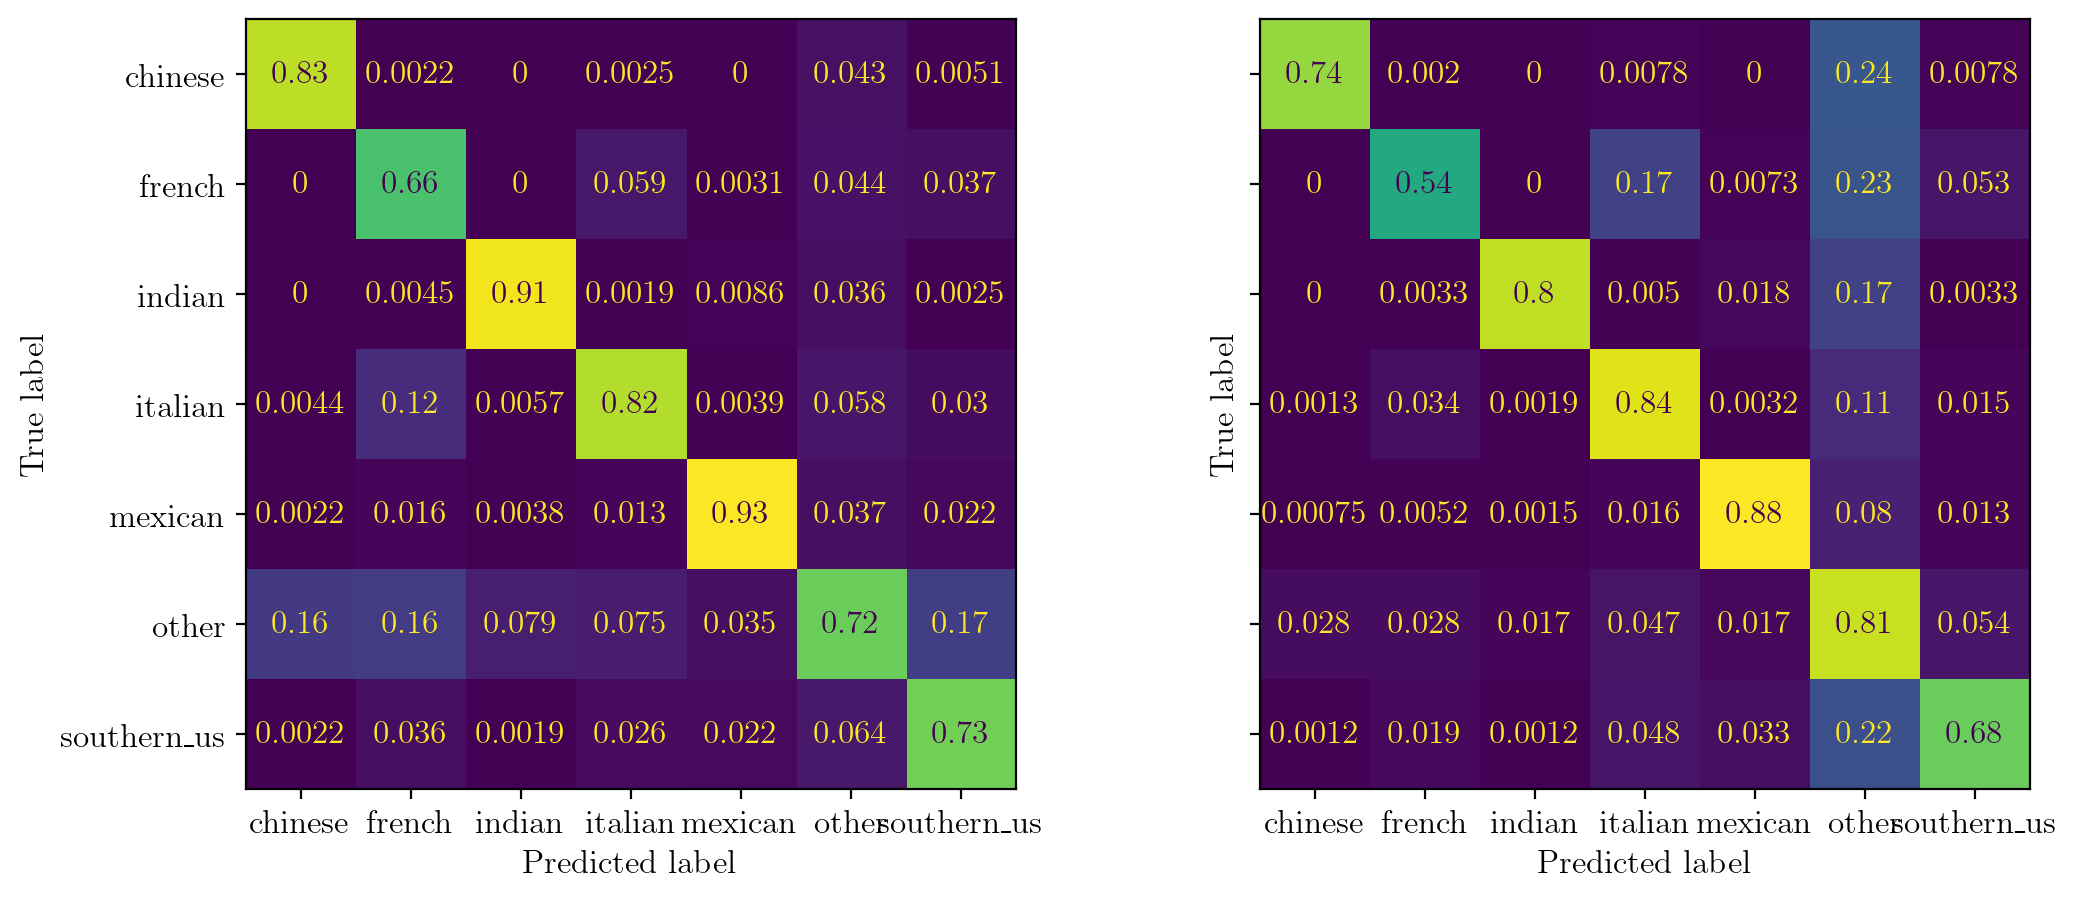

In [34]:
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(12, 5))

ConfusionMatrixDisplay.from_predictions(y_true=y_test,
                                        y_pred=y_pred,
                                        normalize='pred',
                                        labels=model_pipe.classes_,
                                        ax=ax[0], colorbar=False)
ConfusionMatrixDisplay.from_predictions(y_true=y_test,
                                        y_pred=y_pred,
                                        normalize='true',
                                        labels=model_pipe.classes_,
                                        ax=ax[1], colorbar=False)